# Cluster Analysis for Business - Course paper

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
import time
from sklearn.manifold import TSNE
import seaborn as sns
from numpy import linalg as LA
from sklearn.cluster import DBSCAN
import tensorflow as tf
import os
import warnings

## 1) Clustering and Representation Learning

### i) 

In [37]:
# Loading the data
path ='https://raw.githubusercontent.com/milaan9/Clustering-Datasets/refs/heads/master/02.%20Synthetic/banana.csv'
data = pd.read_csv(path)
data.head()

,x,y,class
0,0.228,0.559,1
1,0.216,0.528,1
2,0.221,0.552,1
3,0.215,0.538,1
4,0.224,0.548,1


### a) Visualize the data in a 2-dimensional scatter plot

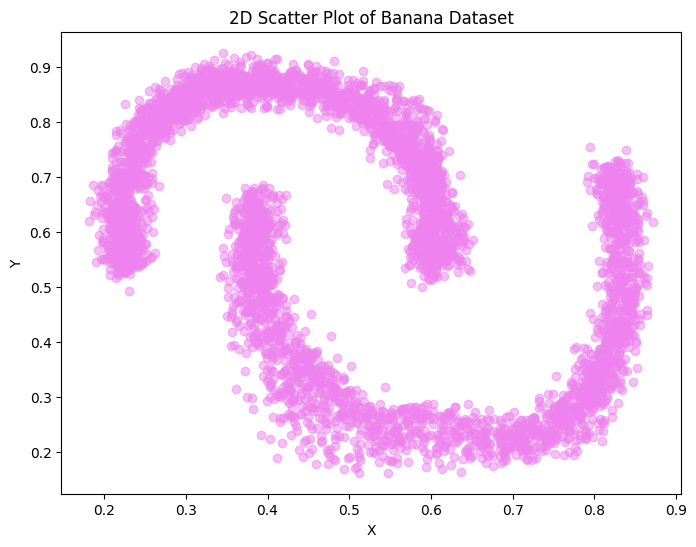

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c='violet', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Scatter Plot of Banana Dataset')
plt.show()

### c) Use the Euclidean distance and the ward and average linkage methods and plot the dendrogram for both linkage methods. Discuss the number of clusters that the dendrograms suggest and contrast the result with your answer in b)

In [43]:
x = data[['x', 'y']].values
cl_ward = linkage(x, method='ward', metric='euclidean')

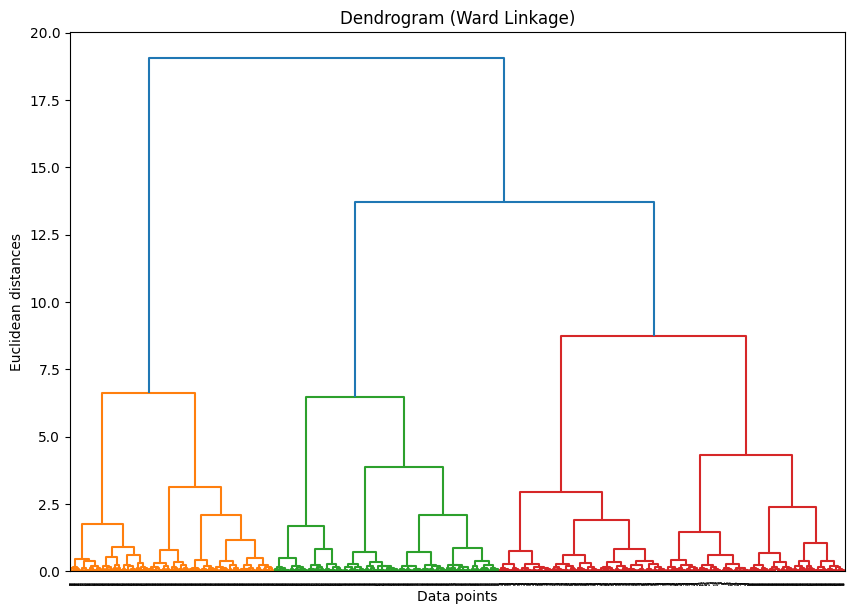

In [7]:
# Dendogram with Ward Linkage
plt.figure(figsize=(10, 7))
plt.title('Dendrogram (Ward Linkage)')
dendrogram(cl_ward, leaf_font_size=0)
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

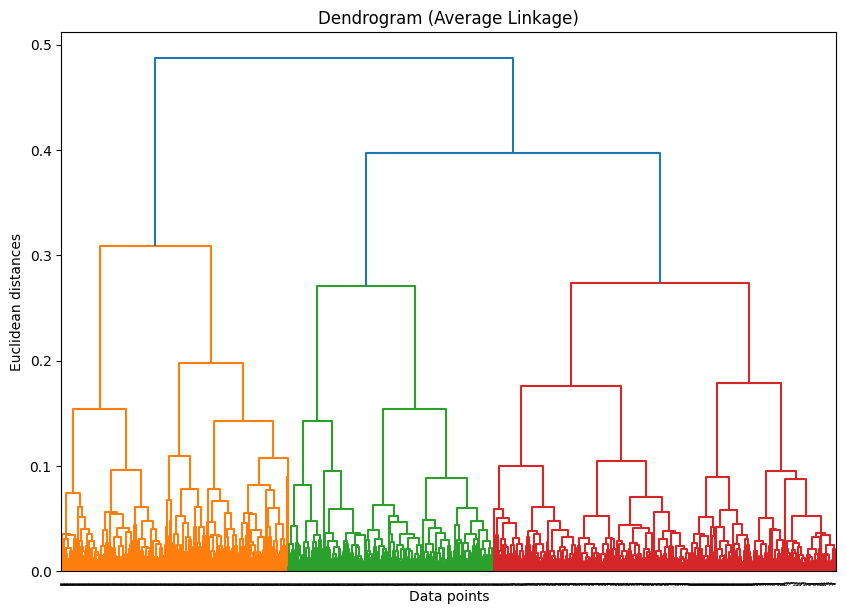

In [8]:
# Dendogram with Single Linkage
cl_average = linkage(x, method='average', metric='euclidean')
plt.figure(figsize=(10, 7))
plt.title('Dendrogram (Average Linkage)')
dendrogram(cl_average, leaf_font_size=0)
plt.xlabel('Data points')
plt.ylabel('Euclidean distances')
plt.show()

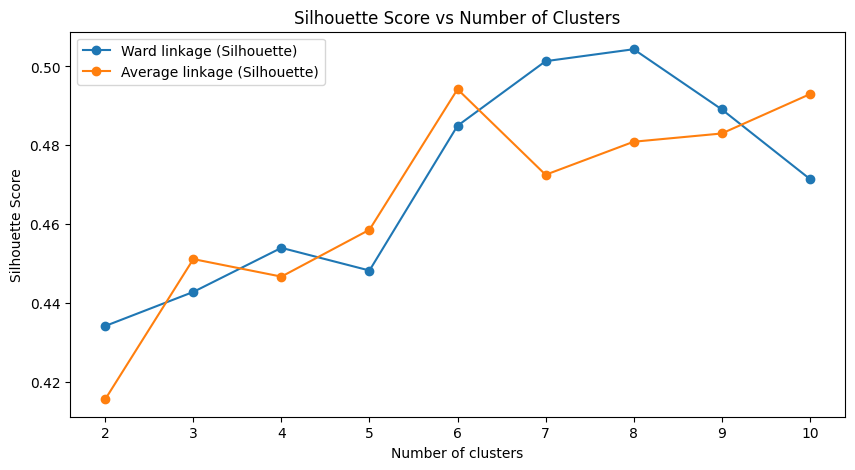

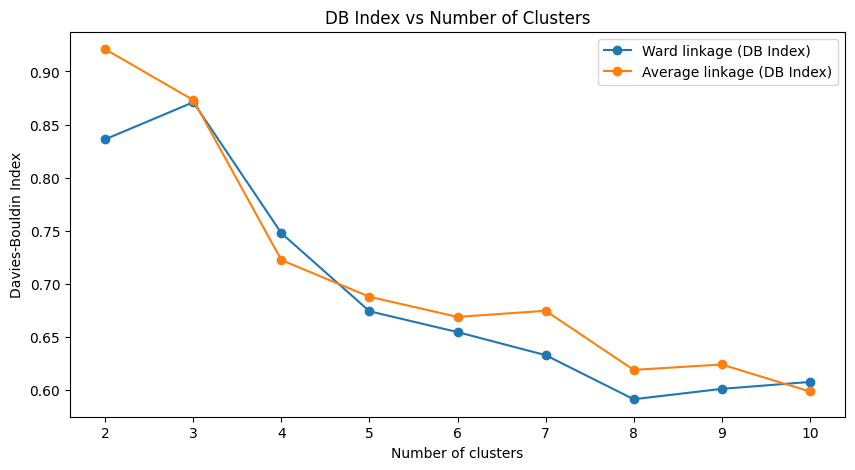

In [9]:
# Silhouette Score and Davies-Bouldin Index
k_range = range(2, 11) # evaluate the number of clusters from 2 to 10

silhouette_ward_scores = []
db_ward_scores = []
silhouette_average_scores = []
db_average_scores = []

for k in k_range:
    labels_ward = fcluster(cl_ward, k, criterion='maxclust')
    silhouette_ward_scores.append(silhouette_score(x, labels_ward))
    db_ward_scores.append(davies_bouldin_score(x, labels_ward))

    labels_average = fcluster(cl_average, k, criterion='maxclust')
    silhouette_average_scores.append(silhouette_score(x, labels_average))
    db_average_scores.append(davies_bouldin_score(x, labels_average))

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_ward_scores, label='Ward linkage (Silhouette)', marker='o')
plt.plot(k_range, silhouette_average_scores, label='Average linkage (Silhouette)', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(k_range, db_ward_scores, label='Ward linkage (DB Index)', marker='o')
plt.plot(k_range, db_average_scores, label='Average linkage (DB Index)', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('DB Index vs Number of Clusters')
plt.legend()
plt.show()

### d) Select the K parameter based on your answer in exercise b), run the K-means algorithm, and visualize a 2-dimensional scatter plot where the K-means cluster labels are used as colors in the scatters. Comment on the results.

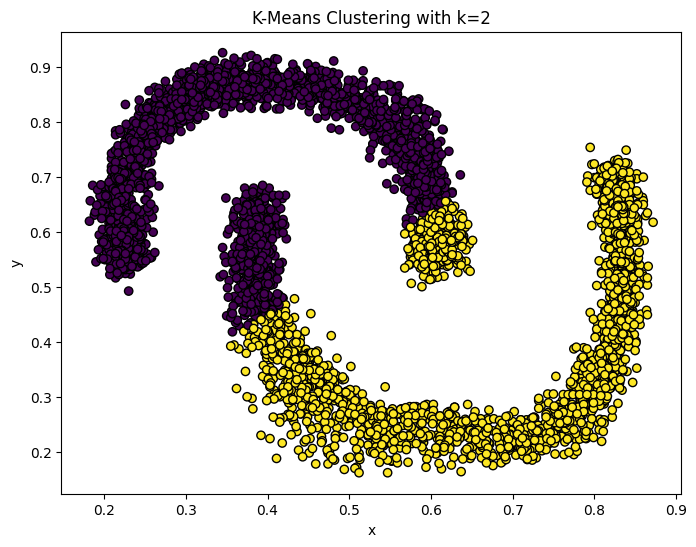

In [44]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(x)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering with k=2')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### ii) - v) 

In [45]:
# Autoencoder definition
labels = data['class'].copy().to_numpy()
y = tf.keras.utils.to_categorical(labels-1,num_classes=2)
class AutoEncoder(tf.keras.Model):
    def __init__(self, enc, dec, name='autoencoder'):
      super().__init__()
      self.encoder = enc
      self.decoder = dec
      self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

      self.params = encoder.trainable_variables + decoder.trainable_variables

    def call(self, inputs):
      x,y = inputs
      z = self.encoder(x)
      x_hat = self.decoder(z)

      self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, x_hat))

    @tf.function
    def train(self, x, optimizer):
        with tf.GradientTape() as tape:
            enc_dec = self.call(x)
        gradients = tape.gradient(self.loss, self.params)
        optimizer.apply_gradients(zip(gradients, self.params))

        return self.loss

    def rep_learning(self, x):
      z = self.encoder(x)

      return z

    def reconstruct(self, x):
      z = self.rep_learning(x)
      x_hat = self.decoder(z)

      return x_hat

In [47]:
print(f'x shape: {x.shape}')

x shape: (4811, 2)


In [48]:
# Hyperparameters
input_shape = (2, )
activation = 'tanh'
units = 10
z_dim = 2

In [49]:
# Encoder and decoder architecture
encoder = Sequential([
    layers.InputLayer(input_shape=(input_shape)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(z_dim, activation='linear'),    # output layer (latent space) with linear activation
])

decoder = Sequential([
    layers.InputLayer(input_shape=(z_dim,)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(2, activation='linear'),  # output layer with linear activation
])

warnings.filterwarnings("ignore", category=UserWarning, message="Argument `input_shape` is deprecated. Use `shape` instead.")

In [50]:
# Training the autoencoder
seed = 42 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

autoencoder = AutoEncoder(encoder, decoder)
batch_size = 256
tr_data = tf.data.Dataset.from_tensor_slices((x,y)).shuffle(x.shape[0]).batch(batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

counter = 0
epochs  = 1000
start = time.time()
losses = []
while counter < epochs:
  for i, x_batch in enumerate(tr_data):
    loss = autoencoder.train(x_batch, optimizer)
    losses.append(loss.numpy())  # storing loss
  counter+=1
  if counter%10==0:
    print('Model has been trained for {} epochs'.format(counter))
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print('Elapsed time: {}m {:.1f}s'.format(int(minutes), seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

Model has been trained for 10 epochs
Model has been trained for 20 epochs
Model has been trained for 30 epochs
Model has been trained for 40 epochs
Model has been trained for 50 epochs
Model has been trained for 60 epochs
Model has been trained for 70 epochs
Model has been trained for 80 epochs
Model has been trained for 90 epochs
Model has been trained for 100 epochs
Model has been trained for 110 epochs
Model has been trained for 120 epochs
Model has been trained for 130 epochs
Model has been trained for 140 epochs
Model has been trained for 150 epochs
Model has been trained for 160 epochs
Model has been trained for 170 epochs
Model has been trained for 180 epochs
Model has been trained for 190 epochs
Model has been trained for 200 epochs
Model has been trained for 210 epochs
Model has been trained for 220 epochs
Model has been trained for 230 epochs
Model has been trained for 240 epochs
Model has been trained for 250 epochs
Model has been trained for 260 epochs
Model has been traine

### e) Plot the loss across number of epochs and generate the latent representation for all data using the function rep_learning and visualize it in a 2-dimensional scatter plot

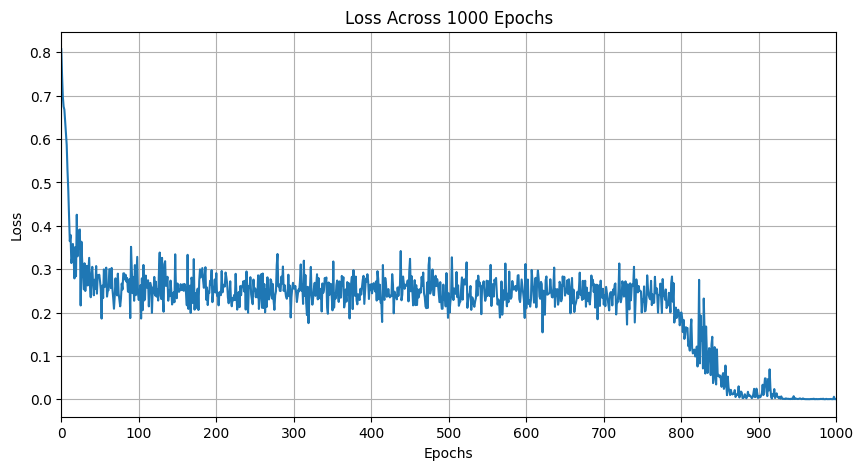

plotting nice scatter...


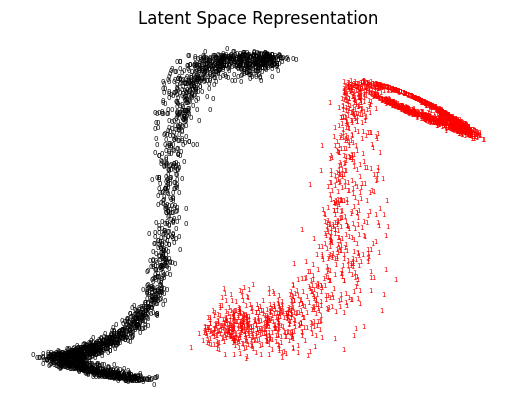

In [13]:
plt.figure(figsize=(10, 5))  
plt.plot(losses[:epochs])  
plt.xlim([0, epochs])  
plt.xticks(range(0, epochs + 1, 100))  
plt.title('Loss Across 1000 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  
plt.show()

def nice_scatter(z_tsne, y_sample, title):
    print('plotting nice scatter...')
    COLORS=[[1.0000, 0,      0     ],
            [0,      1.0000, 0     ],
            [0,      0,      1.0000],
            [1.0000, 0,      1.0000],
            [0.9569, 0.6431, 0.3765],
            [0.4000, 0.8039, 0.6667],
            [0.5529, 0.7137, 0.8039],
            [0.8039, 0.5882, 0.8039],
            [0.7412, 0.7176, 0.4196],
            [0,      0,      0     ]]

    fig, ax = plt.subplots()
    for i, ((x,y),) in enumerate(zip(z_tsne)):
        #rot = random.randint(0,0) # in case you want randomly rotated numbers
        rot = 0
        ax.text(x, y, y_sample[i], color=COLORS[y_sample[i]-1], ha="center", va="center", rotation = rot, fontsize=5)
        ax.plot(x,y, alpha=0.0)
        ax.axis('off')
        plt.title(title)

z = autoencoder.rep_learning(x)
y_sample = np.argmax(y, axis=1)
nice_scatter(z, y_sample, title="Latent Space Representation")

In [27]:
### DO NOT RUN AGAIN !!! (already savedo)
# np.save('lentent_z.npy',z)

### f) Use K-means again, but this time you will cluster the latent representations that you obtained in exercise f). Visualize the latent representation and use the K-means cluster labels as colors in the scatters. Comment on the results.

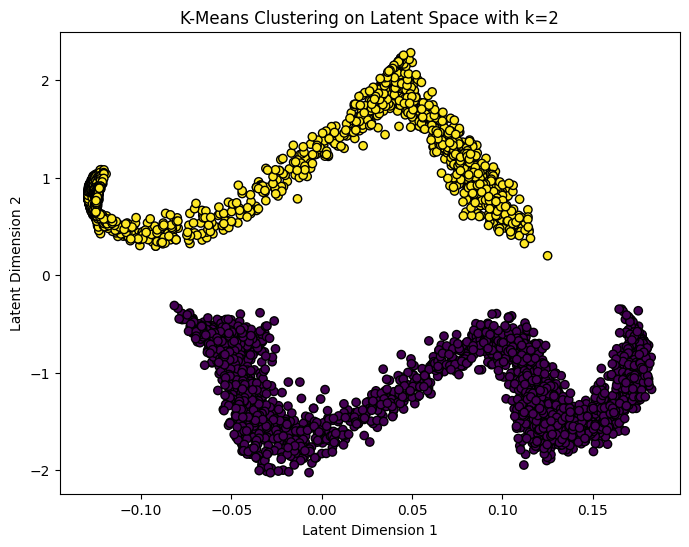

In [14]:
latent_z = np.load('lentent_z.npy')

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(latent_z)  
labels = kmeans.labels_  

plt.figure(figsize=(8, 6))
plt.scatter(latent_z[:, 0], latent_z[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('K-Means Clustering on Latent Space with k=2')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

### g) Can you think of a clustering algorithm that is better suited for this data set? Explain the mechanism behind such an algorithm

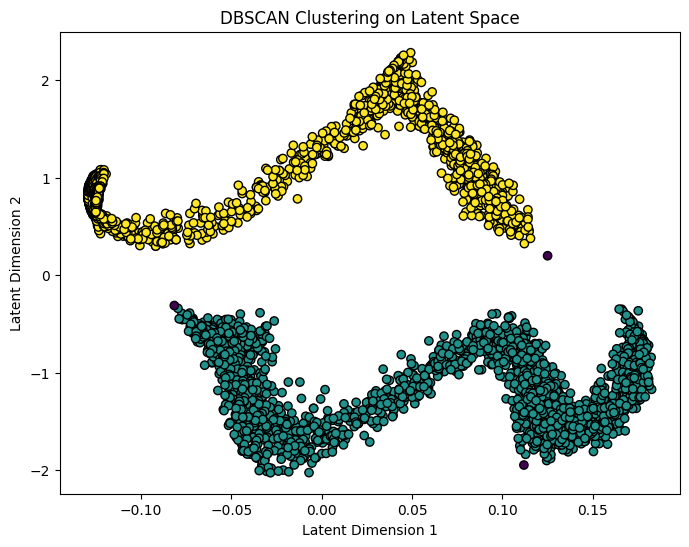

In [15]:
dbscan = DBSCAN(eps=0.055, min_samples=5)
labels_dbscan = dbscan.fit_predict(latent_z)

plt.figure(figsize=(8, 6))
plt.scatter(latent_z[:, 0], latent_z[:, 1], c=labels_dbscan, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering on Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

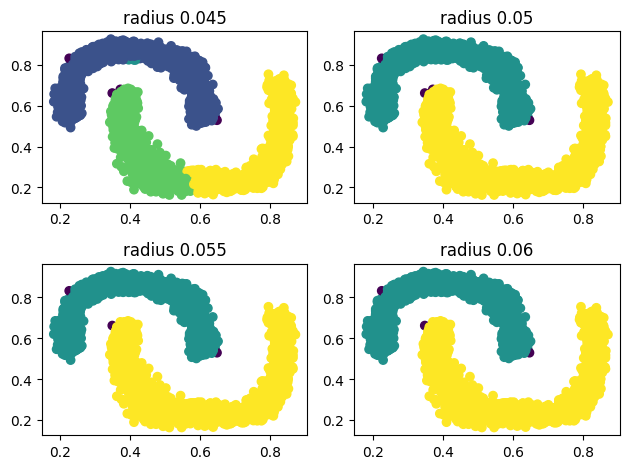

In [16]:
# DBSCAN with different radius
radius = [0.045, 0.05, 0.055, 0.06]
fig, ax = plt.subplots(2,2)
c=0
for i in range(2):
  for j in range(2):
    dbscan = DBSCAN(eps=radius[c], min_samples=5, metric='euclidean')
    labels = dbscan.fit_predict(latent_z)
    ax[i,j].scatter(x[:,0],x[:,1],c=labels)
    ax[i,j].set_title('radius {}'.format(radius[c]))
    c+=1
plt.tight_layout()
plt.show()


## 2) Retail Store Business Case

### i)

In [51]:
# Loading the data
path = 'retail_store_data.csv'
original_df = pd.read_csv(path)
original_df.head()

,Education,Marital_Status,Income,Kids,Days_is_client,Recency,Expenses,CustomerAge,TotalNumPurchases,TotalAcceptedCmp,Complain,Response
0,Graduate,Single,58138.0,0,663,58,1617,57,25,0,0,1
1,Graduate,Single,46344.0,2,113,38,27,60,6,0,0,0
2,Graduate,Partner,71613.0,0,312,26,776,49,21,0,0,0
3,Graduate,Partner,26646.0,1,139,26,53,30,8,0,0,0
4,Postgraduate,Partner,58293.0,1,161,94,422,33,19,0,0,0


### ii)

In [52]:
# Checking for missing values in each feature
display(original_df.isnull().any())

Education            False
Marital_Status       False
Income               False
Kids                 False
Days_is_client       False
Recency              False
Expenses             False
CustomerAge          False
TotalNumPurchases    False
TotalAcceptedCmp     False
Complain             False
Response             False
dtype: bool

In [54]:
print(f'retail_store_data shaper: {original_df.shape}')

retail_store_data shaper: (2216, 12)


In [55]:
# Checking for duplicates
print(f'Duplicates before removal: {original_df.duplicated().sum()}')

# Removing duplicates
df = original_df.drop_duplicates()
print(f'Duplicates after removal: {df.duplicated().sum()}')

Duplicates before removal: 185
Duplicates after removal: 0


In [56]:
# Identifying the categorical and numerical variables
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

print(f"Categorical Variables: {list(cat_cols)}")
print(f"Numerical Variables: {list(num_cols)}")

Categorical Variables: ['Education', 'Marital_Status']
Numerical Variables: ['Income', 'Kids', 'Days_is_client', 'Recency', 'Expenses', 'CustomerAge', 'TotalNumPurchases', 'TotalAcceptedCmp', 'Complain', 'Response']


In [57]:
df.describe(include='number').round(2).T

,count,mean,std,min,25%,50%,75%,max
Income,2031.0,52376.80,25539.84,1730.0,35533.5,51563.0,68557.0,666666.0
Kids,2031.0,0.95,0.75,0.0,0.0,1.0,1.0,3.0
Days_is_client,2031.0,352.56,202.34,0.0,178.0,352.0,528.0,699.0
Recency,2031.0,48.89,28.97,0.0,24.0,49.0,74.0,99.0
Expenses,2031.0,608.26,603.75,5.0,69.0,397.0,1048.5,2525.0
CustomerAge,2031.0,45.21,11.98,18.0,37.0,44.0,55.0,121.0
TotalNumPurchases,2031.0,14.89,7.66,0.0,8.0,15.0,21.0,44.0
TotalAcceptedCmp,2031.0,0.30,0.68,0.0,0.0,0.0,0.0,4.0
Complain,2031.0,0.01,0.10,0.0,0.0,0.0,0.0,1.0
Response,2031.0,0.15,0.36,0.0,0.0,0.0,0.0,1.0


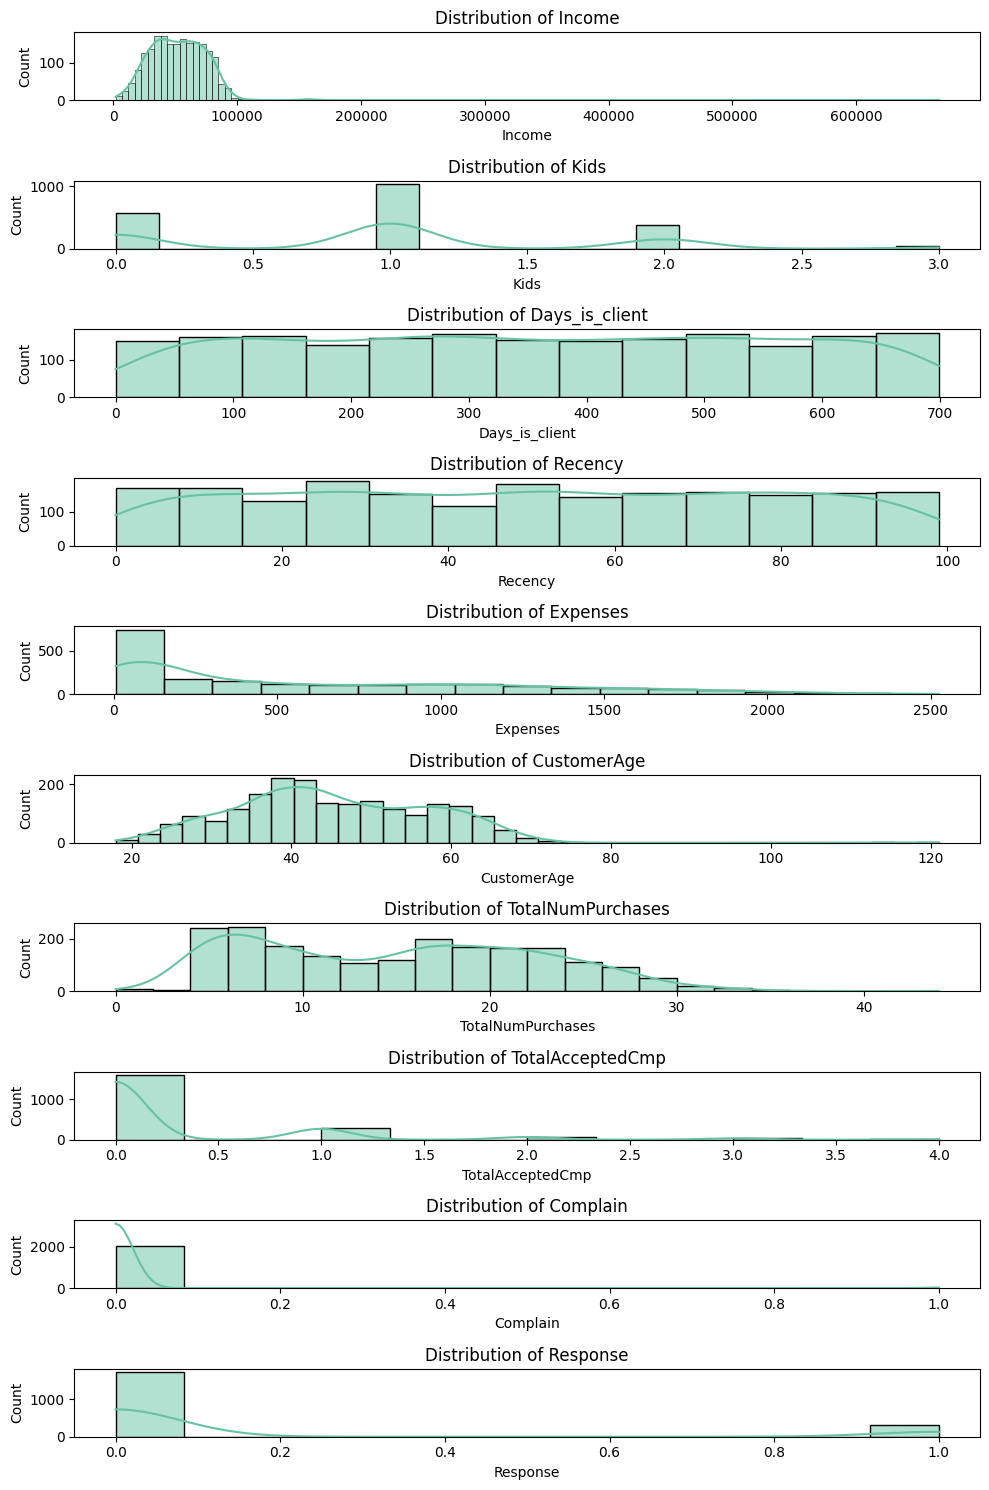

In [83]:
# Plotting the distribution of the numerical variables
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 15))

for i, col in enumerate(num_cols):
        sns.histplot(data=df, x=col, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

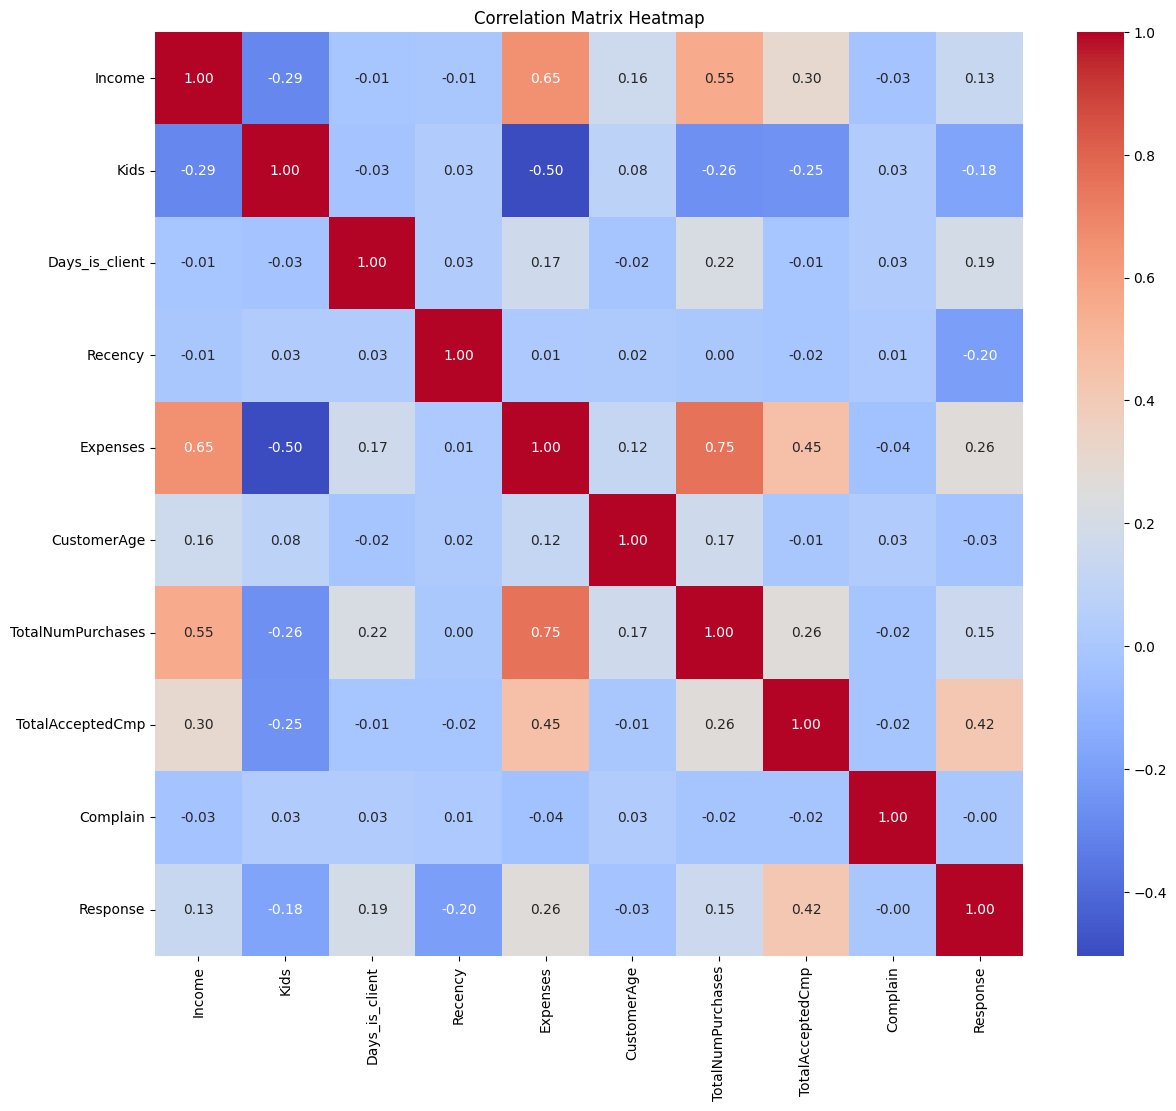

In [148]:
# Plotting the correlation matrix between numerical variables as a heatmap
num_cols = df.select_dtypes(include=np.number).columns.tolist() 
correlation_matrix = df[num_cols].corr() 
plt.figure(figsize=(14, 12)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True) 
plt.title("Correlation Matrix Heatmap")

In [16]:
df.describe(include='object').round(2).T

,count,unique,top,freq
Education,2031,3,Graduate,1203
Marital_Status,2031,2,Partner,1302


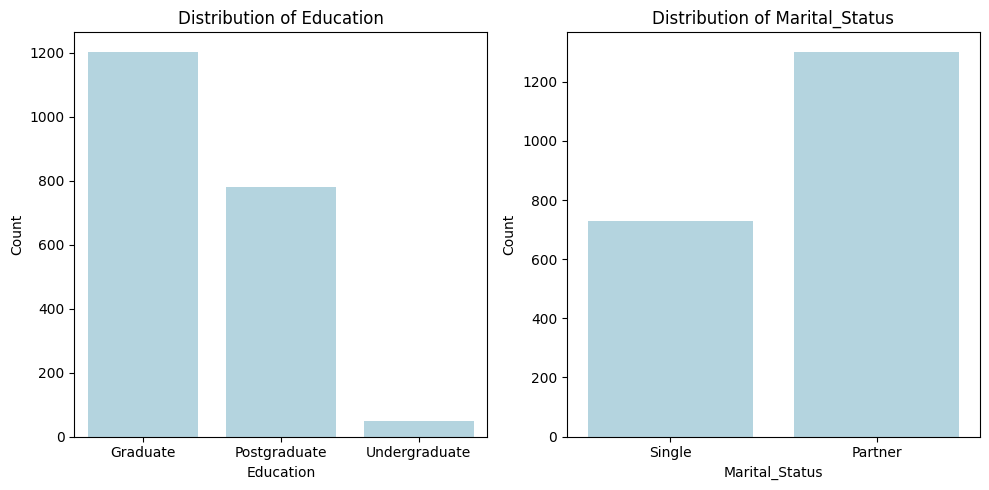

In [17]:
# Plotting the distribution of the categorical variables
fig, axes = plt.subplots(1, len(cat_cols), figsize=(10, 5))

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, ax=axes[i], color='#ADD8E6')  
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### a) What can you say about the data? Recall that it will be used to identify clusters, or groups of customers, in the retail store

### iii)

In [58]:
df_encoded = pd.get_dummies(df, columns=cat_cols, dtype =int)
df_encoded.head()

,Income,Kids,Days_is_client,Recency,Expenses,CustomerAge,TotalNumPurchases,TotalAcceptedCmp,Complain,Response,Education_Graduate,Education_Postgraduate,Education_Undergraduate,Marital_Status_Partner,Marital_Status_Single
0,58138.0,0,663,58,1617,57,25,0,0,1,1,0,0,0,1
1,46344.0,2,113,38,27,60,6,0,0,0,1,0,0,0,1
2,71613.0,0,312,26,776,49,21,0,0,0,1,0,0,1,0
3,26646.0,1,139,26,53,30,8,0,0,0,1,0,0,1,0
4,58293.0,1,161,94,422,33,19,0,0,0,0,1,0,1,0


### iv)

In [59]:
# PCA transformation
df_mean = df_encoded.mean(axis=0)
df_encoded -= df_mean
C = np.cov(df_encoded.T)

w, v = LA.eig(C)

inx = w.argsort()[::-1]
w, v = w[inx], v[:, inx]

m = 15
w = w[:m]
v = v[:, :m]
print(f'Eigenvectors shape: {v.shape}')

pca = df_encoded.dot(v)
print(f'PCA shape: {pca.shape}')

Eigenvectors shape: (15, 15)
PCA shape: (2031, 15)


### b) Explain what is the reason for using PCA and not reducing the number of dimensions in the input data

### c) For K = 1, 2, · · · , 10, plot the Silhouette and Davies-Bouldin scores for both hierarchical clustering and K-means, i.e. you are supposed to show 4 plots

In [60]:
K = 10 #how many times we repeat the calculations

hierarchical_cv = {}
kmeans_cv = {}
hierarchical_silhouette = []
hierarchical_db = []
kmeans_silhouette = []
kmeans_db = []

for k in range(2, K+1): # we start at 2, since clustering for K=1 doesnt make sense
  # First hierarchical
  P = linkage(pca, method='ward', metric='euclidean')
  cluster_labels = fcluster(P, k, criterion='maxclust')
  silhouette = silhouette_score(pca, cluster_labels)
  db = davies_bouldin_score(pca,cluster_labels)

  # save results
  temp_dict = {'silhouette':silhouette,'db':db}
  hierarchical_cv[k] = temp_dict
  hierarchical_silhouette.append(silhouette)
  hierarchical_db.append(db)

  # Second kmeans
  kmeans = KMeans(n_clusters=k, n_init="auto")
  cluster_labels = kmeans.fit_predict(pca)
  silhouette = silhouette_score(pca, cluster_labels)
  db  = davies_bouldin_score(pca, cluster_labels)

  # save results
  temp_dict = {'silhouette':silhouette,'db':db}
  kmeans_cv[k] = temp_dict
  kmeans_silhouette.append(silhouette)
  kmeans_db.append(db)


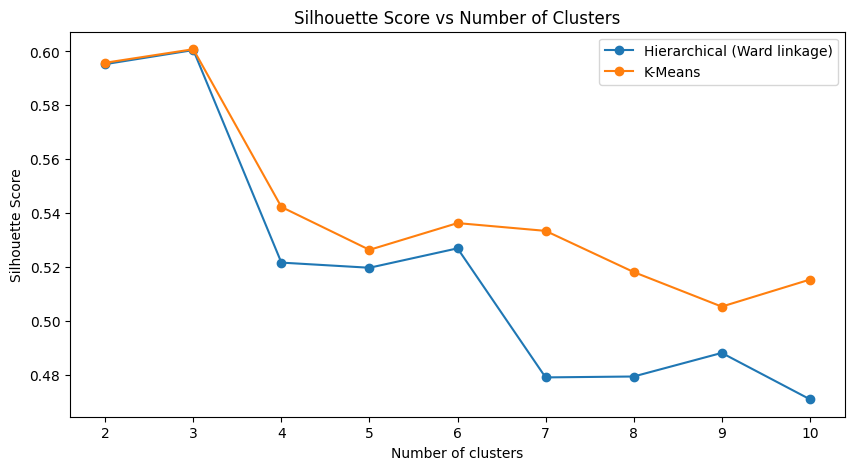

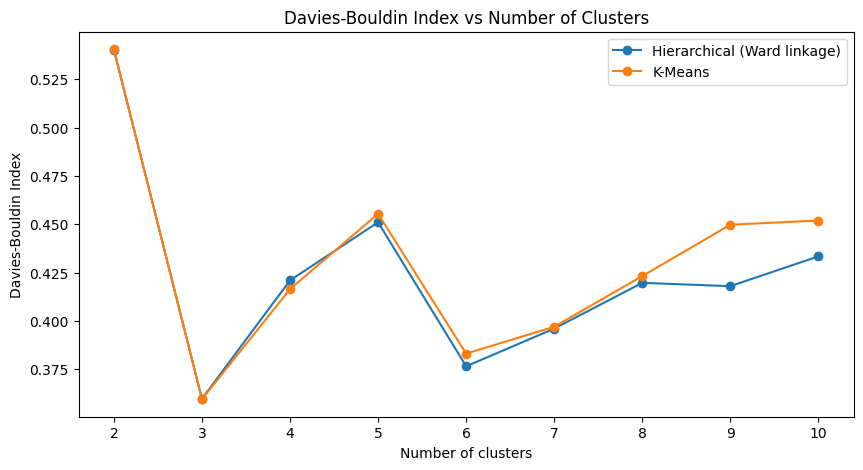

In [25]:
k_range = range(2, K+1)

# Plot the silhouette scores for hierarchical and k-means clustering
plt.figure(figsize=(10, 5))
plt.plot(k_range, hierarchical_silhouette, label='Hierarchical (Ward linkage)', marker='o')
plt.plot(k_range, kmeans_silhouette, label='K-Means', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.show()

# Plot the Davies-Bouldin scores for hierarchical and k-means clustering
plt.figure(figsize=(10, 5))
plt.plot(k_range, hierarchical_db, label='Hierarchical (Ward linkage)', marker='o')
plt.plot(k_range, kmeans_db, label='K-Means', marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.legend()
plt.show()

### d) What are the number of clusters suggested by your cross-validation? Does the Silhouette and Davies-Bouldin scores agree with each other?

### v) - vii)

In [61]:
# Autoencoder definition
class AutoEncoder(tf.keras.Model):
    def __init__(self, enc, dec, name='autoencoder'):
      super().__init__()
      self.encoder = enc
      self.decoder = dec
      self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

      self.params = encoder.trainable_variables + decoder.trainable_variables

    def call(self, inputs):
      z = self.encoder(inputs)
      x_hat = self.decoder(z)

      self.loss = tf.reduce_mean(tf.keras.losses.MSE(inputs,x_hat))

    @tf.function
    def train(self,x, optimizer):
        with tf.GradientTape() as tape:
            enc_dec = self.call(x)
        gradients = tape.gradient(self.loss, self.params)
        optimizer.apply_gradients(zip(gradients, self.params))

        return self.loss

    def rep_learning(self, x):
      z = self.encoder(x)

      return z

    def reconstruct(self, x):
      z = self.rep_learning(x)
      x_hat = self.decoder(z)

      return x_hat

In [62]:
# Hyperparameters
input_shape = (15, )
activation = 'tanh'
units = 35
z_dim = 10

In [63]:
# Encoder and decoder architecture
encoder = Sequential([
    layers.InputLayer(input_shape=(input_shape)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(z_dim, activation='linear'),    # output layer (latent space) with linear activation
])

decoder = Sequential([
    layers.InputLayer(input_shape=(z_dim,)),
    layers.Dense(units, activation=activation),  # 1st hidden layer
    layers.Dense(units, activation=activation),  # 2nd hidden layer
    layers.Dense(units, activation=activation),  # 3rd hidden layer
    layers.Dense(15, activation='linear'),  # output layer with linear activation
])

warnings.filterwarnings("ignore", category=UserWarning, message="Argument `input_shape` is deprecated. Use `shape` instead.")

In [64]:
# Training the autoencoder
seed = 42 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

autoencoder = AutoEncoder(encoder, decoder)
batch_size = 256
tr_data  = tf.data.Dataset.from_tensor_slices(pca).shuffle(pca.shape[0]).batch(batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

counter = 0
epochs  = 1000
start = time.time()
losses = []
while counter < epochs:
  for i, x_batch in enumerate(tr_data):
    loss = autoencoder.train(x_batch, optimizer)
    # losses.append(loss.numpy())  # storing loss
  counter+=1
  if counter%10==0:
    print('Model has been trained for {} epochs'.format(counter))
elapsed_time = time.time() - start
minutes, seconds = divmod(elapsed_time, 60)
print('Elapsed time: {}m {:.1f}s'.format(int(minutes), seconds))

Model has been trained for 10 epochs
Model has been trained for 20 epochs
Model has been trained for 30 epochs
Model has been trained for 40 epochs
Model has been trained for 50 epochs
Model has been trained for 60 epochs
Model has been trained for 70 epochs
Model has been trained for 80 epochs
Model has been trained for 90 epochs
Model has been trained for 100 epochs
Model has been trained for 110 epochs
Model has been trained for 120 epochs
Model has been trained for 130 epochs
Model has been trained for 140 epochs
Model has been trained for 150 epochs
Model has been trained for 160 epochs
Model has been trained for 170 epochs
Model has been trained for 180 epochs
Model has been trained for 190 epochs
Model has been trained for 200 epochs
Model has been trained for 210 epochs
Model has been trained for 220 epochs
Model has been trained for 230 epochs
Model has been trained for 240 epochs
Model has been trained for 250 epochs
Model has been trained for 260 epochs
Model has been traine

### e) Generate the latent representation for all data using the function rep_learning and visualize it in a 2-dimensional scatter plot using the t-SNE dimensionality reduction method

In [157]:
z = autoencoder.rep_learning(pca)
z_2d = TSNE(n_components=2, n_jobs=-1).fit_transform(z)

print(f"Shape of 2D representation: {z_2d.shape}")

Shape of 2D representation: (2031, 2)


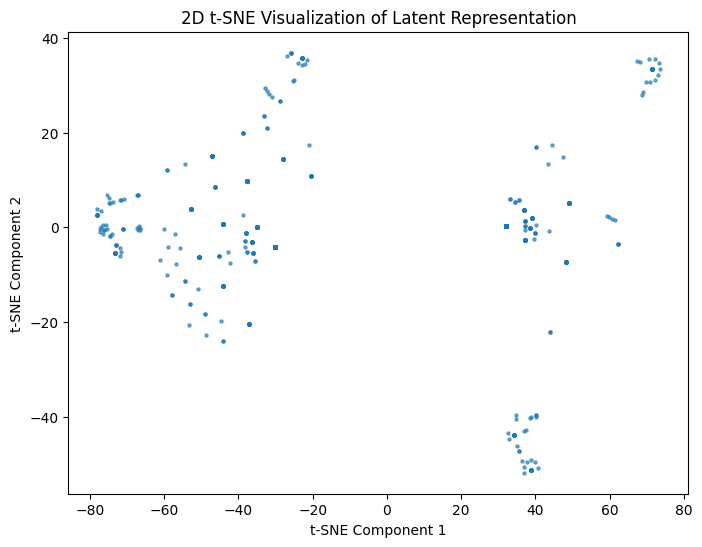

In [353]:
plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], s=5, alpha=0.6)
plt.title("2D t-SNE Visualization of Latent Representation")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

### f) How many clusters can you identify in the scatter plot? Is it similar to the number of clusters that you identified in exercise d)?

### viii)

In [65]:
# K-means clustering
kmeans_pca = KMeans(n_clusters=3, random_state=42)
kmeans_pca.fit(pca)
labels = kmeans_pca.labels_

### g) Write the executive summary for the retail company analyzing each of the clusters. What are the features that distinguish each cluster? Use any method that you consider appropriate, e.g. average values, standard deviations, histograms etc.

In [66]:
pca_clusters = pca.assign(Cluster=labels)
pca_clusters.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Cluster
0,5776.069014,951.164104,194.498201,-7.078760,11.116068,-0.378839,1.161765,0.050119,-0.321110,0.425178,0.743880,0.029322,-0.019802,1.488627e-17,-2.774452e-15,2
1,-6041.035925,-514.075150,-177.812244,9.386709,15.133806,-3.749332,0.890699,0.058350,0.861332,0.478624,-0.047581,0.014324,-0.019775,1.259086e-16,7.855933e-15,2
2,19236.501193,-133.282218,-22.288858,22.384152,2.780221,3.944302,0.277634,-0.876020,-0.915323,-0.084563,-0.038555,-0.011759,-0.011992,-9.613603e-17,-1.008149e-14,0
3,-25736.286918,-183.307294,-195.013501,22.308189,-13.257693,0.309136,-0.061047,-0.689077,-0.103344,0.056965,0.005537,-0.068418,-0.009514,-4.062488e-17,-1.532776e-15,1
4,5912.635116,-299.094190,-154.821140,-46.064192,-12.728603,7.016106,-0.843454,0.440844,-0.482605,-0.008044,0.119826,-0.021940,0.001307,1.488627e-17,-2.448710e-15,2


In [67]:
# Assigning the cluster labels we obtained from K-means to the original dataset
df_clusters = df.assign(Cluster=labels)
df_clusters.head()

,Education,Marital_Status,Income,Kids,Days_is_client,Recency,Expenses,CustomerAge,TotalNumPurchases,TotalAcceptedCmp,Complain,Response,Cluster
0,Graduate,Single,58138.0,0,663,58,1617,57,25,0,0,1,2
1,Graduate,Single,46344.0,2,113,38,27,60,6,0,0,0,2
2,Graduate,Partner,71613.0,0,312,26,776,49,21,0,0,0,0
3,Graduate,Partner,26646.0,1,139,26,53,30,8,0,0,0,1
4,Postgraduate,Partner,58293.0,1,161,94,422,33,19,0,0,0,2


In [69]:
cluster_counts = df_clusters['Cluster'].value_counts().sort_index()

# Display the number of observations in each cluster
cluster_counts_table = pd.DataFrame(cluster_counts).reset_index()
cluster_counts_table.columns = ['Cluster', 'Number of Observations']
cluster_counts_table

,Cluster,Number of Observations
0,0,544
1,1,710
2,2,777


In [70]:
# Displaying cluster statistics
cat_cols = df_clusters.select_dtypes(include=['object']).columns
num_cols = df_clusters.select_dtypes(include=np.number).columns

for cluster in df_clusters['Cluster'].unique():
    print(f"\nCluster {cluster}")
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster]
    
    # For numerical features
    print("Numerical Features Statistics:")
    display(cluster_data.describe(include='number').round(2).T)
    
    # For categorical features
    print("Categorical Features Mode:")
    display(cluster_data.describe(include='object').round(2).T)


Cluster 2
Numerical Features Statistics:


,count,mean,std,min,25%,50%,75%,max
Income,777.0,54454.54,7485.15,41713.0,47889.0,54450.0,61180.0,67131.0
Kids,777.0,1.16,0.68,0.0,1.0,1.0,2.0,3.0
Days_is_client,777.0,354.56,199.83,2.0,188.0,352.0,526.0,699.0
Recency,777.0,49.44,28.86,0.0,25.0,50.0,74.0,99.0
Expenses,777.0,557.37,409.93,15.0,222.0,468.0,858.0,1895.0
CustomerAge,777.0,48.18,10.93,22.0,40.0,48.0,57.0,121.0
TotalNumPurchases,777.0,16.95,6.97,4.0,12.0,17.0,22.0,35.0
TotalAcceptedCmp,777.0,0.21,0.50,0.0,0.0,0.0,0.0,4.0
Complain,777.0,0.01,0.09,0.0,0.0,0.0,0.0,1.0
Response,777.0,0.11,0.31,0.0,0.0,0.0,0.0,1.0


Categorical Features Mode:


,count,unique,top,freq
Education,777,2,Graduate,436
Marital_Status,777,2,Partner,500



Cluster 0
Numerical Features Statistics:


,count,mean,std,min,25%,50%,75%,max
Income,544.0,79970.45,27781.53,67225.0,71840.00,77261.5,82356.25,666666.0
Kids,544.0,0.39,0.60,0.0,0.00,0.0,1.00,3.0
Days_is_client,544.0,347.74,205.61,0.0,166.75,352.0,525.00,697.0
Recency,544.0,48.48,29.68,0.0,23.00,48.0,73.25,99.0
Expenses,544.0,1343.64,466.14,6.0,1015.00,1347.0,1674.50,2525.0
CustomerAge,544.0,46.34,13.03,19.0,37.00,45.0,56.00,115.0
TotalNumPurchases,544.0,20.85,5.02,0.0,17.00,21.0,24.00,44.0
TotalAcceptedCmp,544.0,0.70,1.01,0.0,0.00,0.0,1.00,4.0
Complain,544.0,0.00,0.06,0.0,0.00,0.0,0.00,1.0
Response,544.0,0.26,0.44,0.0,0.00,0.0,1.00,1.0


Categorical Features Mode:


,count,unique,top,freq
Education,544,2,Graduate,334
Marital_Status,544,2,Partner,344



Cluster 1
Numerical Features Statistics:


,count,mean,std,min,25%,50%,75%,max
Income,710.0,28960.82,8783.88,1730.0,23239.0,30514.5,36136.00,41658.0
Kids,710.0,1.15,0.69,0.0,1.0,1.0,2.00,3.0
Days_is_client,710.0,354.06,202.76,0.0,175.5,351.5,531.75,697.0
Recency,710.0,48.60,28.57,0.0,24.0,49.0,74.00,99.0
Expenses,710.0,100.50,131.79,5.0,35.0,57.0,101.00,1730.0
CustomerAge,710.0,41.09,11.05,18.0,33.0,40.0,47.00,114.0
TotalNumPurchases,710.0,8.08,4.12,0.0,5.0,7.0,10.00,43.0
TotalAcceptedCmp,710.0,0.09,0.30,0.0,0.0,0.0,0.00,2.0
Complain,710.0,0.02,0.13,0.0,0.0,0.0,0.00,1.0
Response,710.0,0.12,0.32,0.0,0.0,0.0,0.00,1.0


Categorical Features Mode:


,count,unique,top,freq
Education,710,3,Graduate,433
Marital_Status,710,2,Partner,458


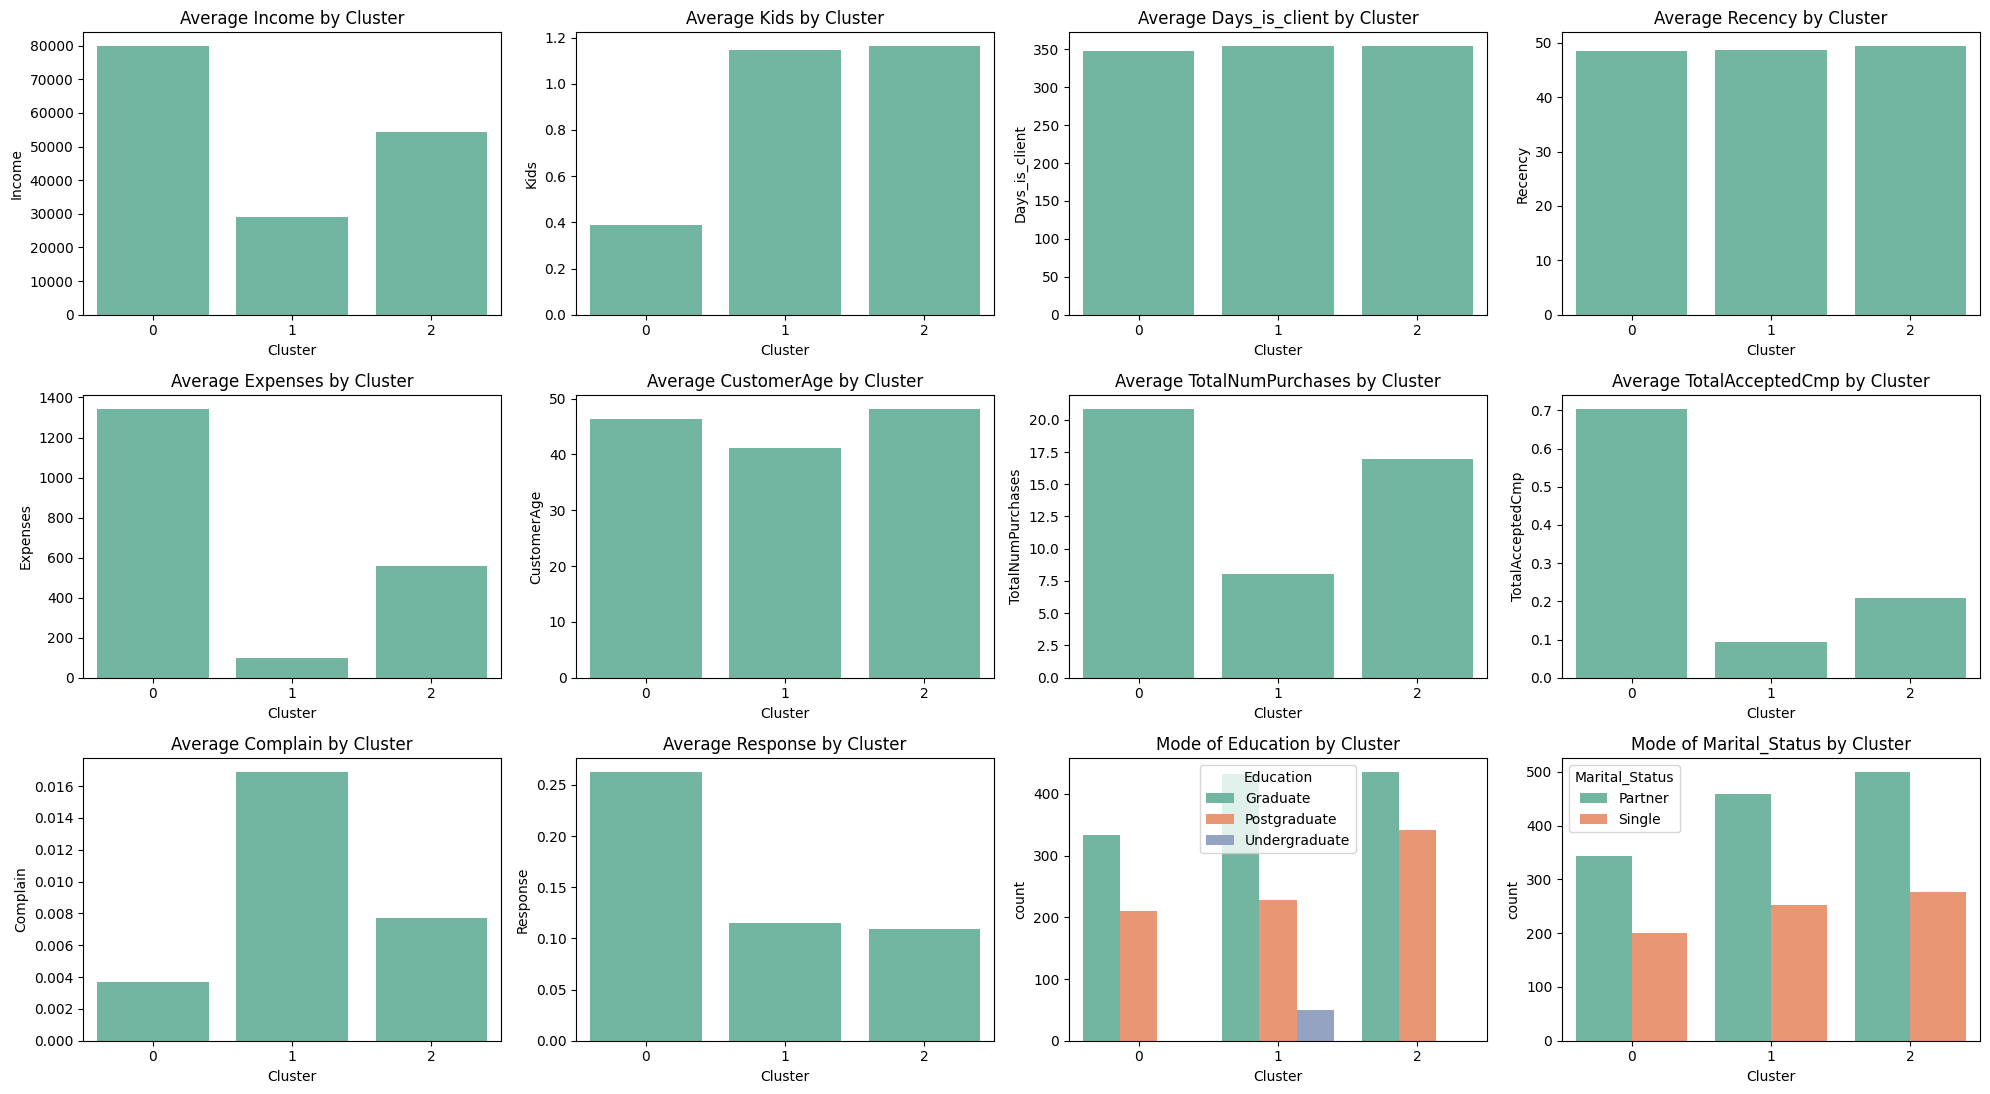

In [97]:
# Plotting the distribution of the numerical features by cluster
plt.style.use('default')
sns.set_palette("Set2")

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.ravel() 

# Plot numerical features (average by cluster)
for i, feature in enumerate(num_cols):
    if feature == 'Cluster':
        continue
    sns.barplot(data=df_clusters, x='Cluster', y=feature, errorbar=None, ax=axes[i])
    axes[i].set_title(f"Average {feature} by Cluster")

# Plot categorical features (mode by cluster)
for j, feature in enumerate(cat_cols, start=len(num_cols)-1):
    sns.countplot(data=df_clusters, x='Cluster', hue=feature, ax=axes[j])
    axes[j].set_title(f"Mode of {feature} by Cluster")
    axes[j].legend(title=feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

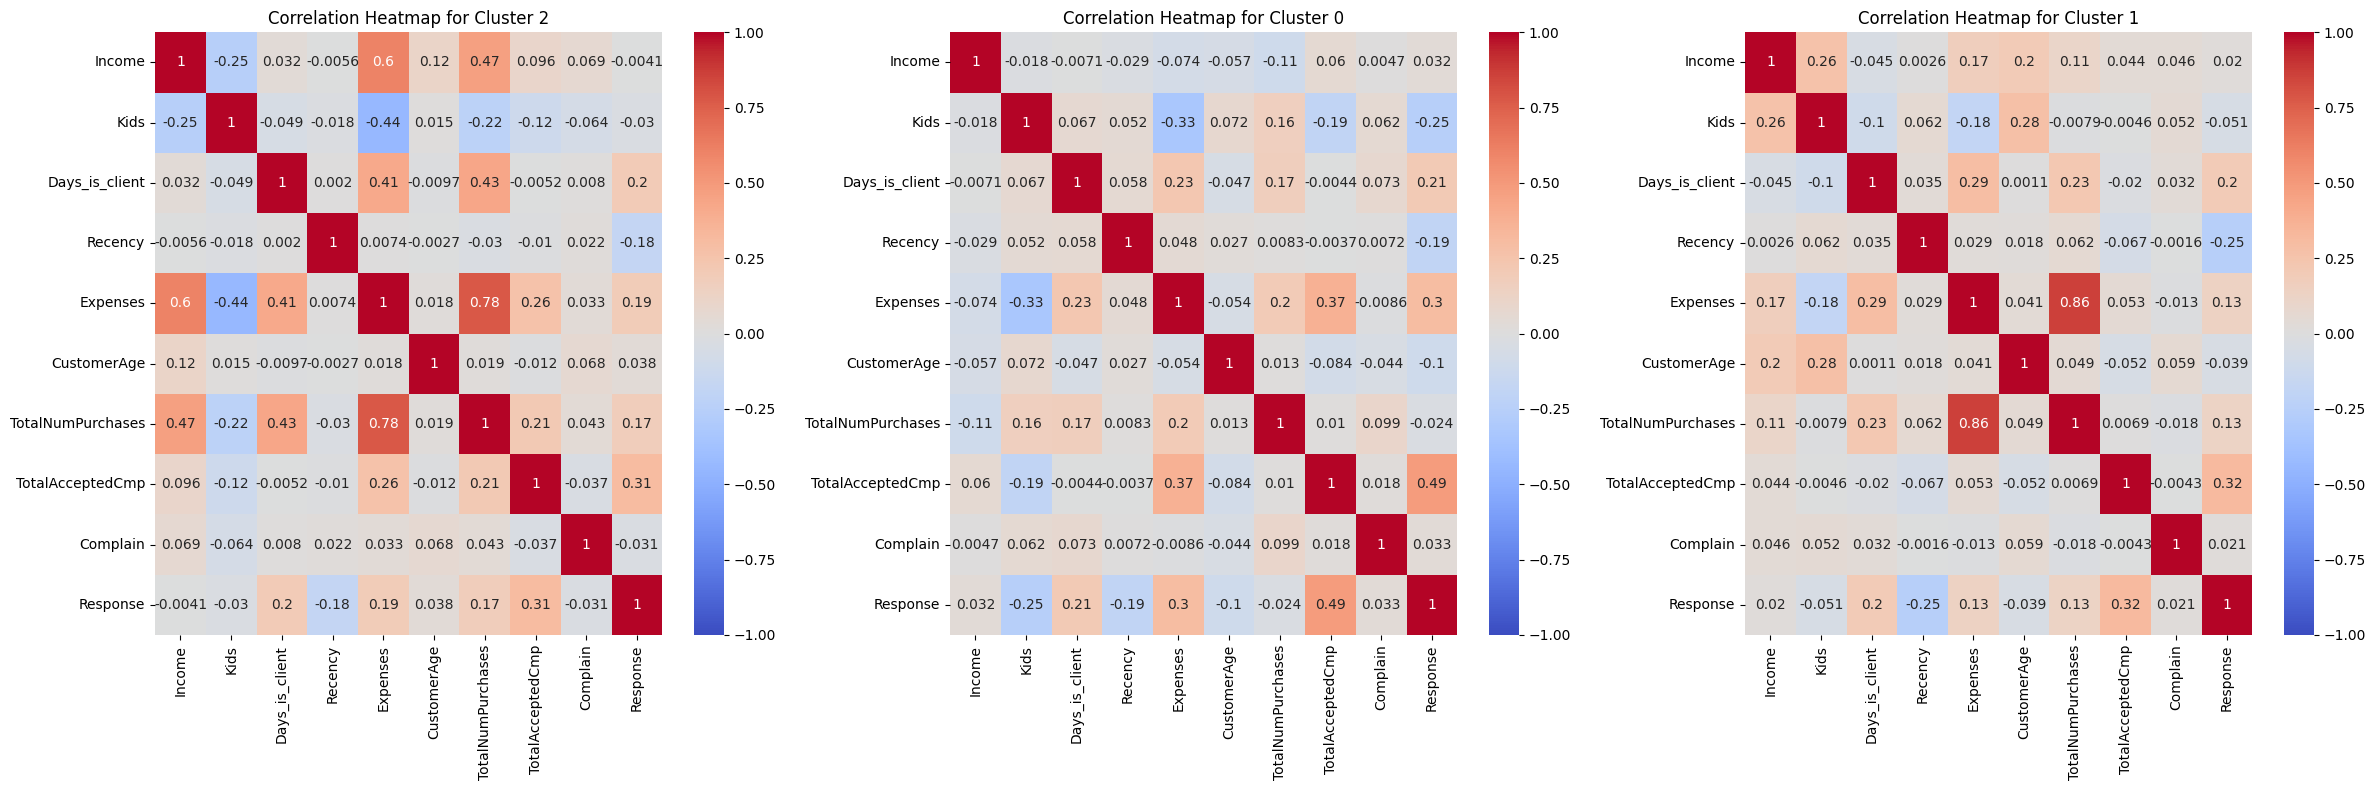

In [98]:
# Plotting the correlation heatmap for each cluster
num_cols_without_cluster = [col for col in num_cols if col != 'Cluster']
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for idx, cluster in enumerate(df_clusters['Cluster'].unique()):
    sns.heatmap(df_clusters[df_clusters['Cluster'] == cluster][num_cols_without_cluster].corr(),
                annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[idx])
    axes[idx].set_title(f"Correlation Heatmap for Cluster {cluster}")

plt.tight_layout()
plt.show()

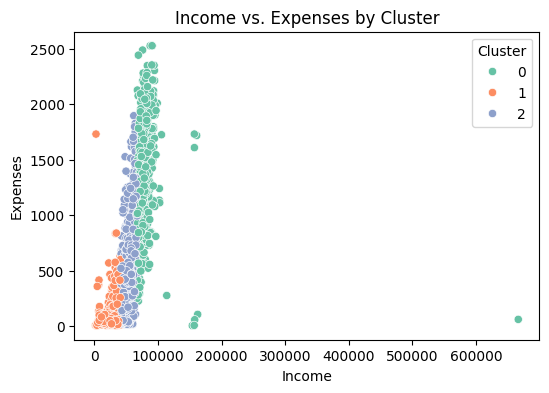

In [99]:
# Plotting the income vs. expenses by cluster
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_clusters, x='Income', y='Expenses', hue='Cluster', palette="Set2")
plt.title("Income vs. Expenses by Cluster")
plt.xlabel("Income")
plt.ylabel("Expenses")
plt.legend(title="Cluster")
plt.show()

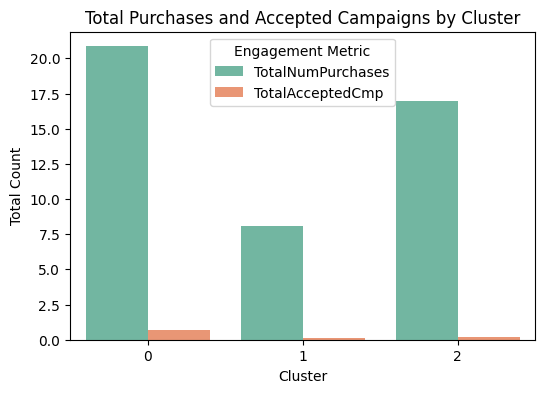

In [103]:
df_melted = pd.melt(df_clusters, id_vars='Cluster', value_vars=['TotalNumPurchases', 'TotalAcceptedCmp'],
                    var_name='EngagementMetric', value_name='Count')

plt.figure(figsize=(6, 4))
sns.barplot(data=df_melted, x='Cluster', y='Count', hue='EngagementMetric', palette="Set2", errorbar=None)
plt.title("Total Purchases and Accepted Campaigns by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Count")
plt.legend(title="Engagement Metric")
plt.show()

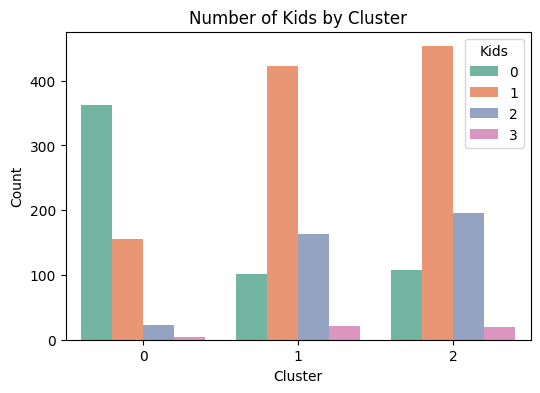

In [105]:
# Plotting the number of kids by cluster
plt.figure(figsize=(6, 4))
sns.countplot(data=df_clusters, x='Cluster', hue='Kids', palette="Set2")
plt.title("Number of Kids by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Kids")
plt.show()